https://github.com/lixiangwang/DAGMM-pytorch/blob/master/dagmm.py
https://github.com/danieltan07/dagmm/blob/master/model.py

In [147]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score
import sys
sys.path.append('..')
import datasets.load_tabular as NAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

In [148]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import torch.nn.init as weight_init
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader 
from torch.autograd import Variable

In [149]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = 'cpu'

In [150]:
class Cholesky(torch.autograd.Function):
    def forward(ctx, a):
        l = torch.linalg.cholesky(a)
        ctx.save_for_backward(l)
        return l
    def backward(ctx, grad_output):
        l, = ctx.saved_tensors
        linv = l.inverse()
        inner = torch.tril(torch.mm(l.t(), grad_output)) * torch.tril(
            1.0 - Variable(l.data.new(l.size(1)).fill_(0.5).diag()))
        s = torch.mm(linv.t(), torch.mm(inner, linv))
        return s

In [151]:
class DAGMM(nn.Module):
    def __init__(self, config):
        super(DAGMM, self).__init__()
        
        #  Compression Network
        
        layers = []
        layers += [nn.Linear(config['input_dim'], config['hidden_dims'][0])]
        layers += [nn.Tanh()]
        for i in range(len(config['hidden_dims'])-1):
            layers += [nn.Linear(config['hidden_dims'][i],config['hidden_dims'][i+1])]
            layers += [nn.Tanh()]        
        layers += [nn.Linear(config['hidden_dims'][-1],config['zc_dim'])]
        
        self.encoder = nn.Sequential(*layers)
        print(self.encoder)
        
        layers = []
        layers += [nn.Linear(config['zc_dim'], config['hidden_dims'][-1])]
        layers += [nn.Tanh()]  
        for i in range(len(config['hidden_dims'])-1):
            layers += [nn.Linear(config['hidden_dims'][-1-i],config['hidden_dims'][-2-i])]
            layers += [nn.Tanh()]        
        layers += [nn.Linear(config['hidden_dims'][0], config['input_dim'])]
        
        self.decoder = nn.Sequential(*layers)
        print(self.decoder)
        
        #  Estimation Network
        
        layers = []
        layers += [nn.Linear(config['zc_dim'] + 2, config['hidden_dims'][-1])]
        layers += [nn.Tanh()]        
        layers += [nn.Dropout(p=config['dropout_rate'])]
        layers += [nn.Linear(config['hidden_dims'][-1],config['n_gmm'])]
        layers += [nn.Softmax(dim=1)]   
        
        
        self.estimation = nn.Sequential(*layers)
        
        self.lambda1 = config['lambda1']
        self.lambda2 = config['lambda2']
        
        
    def compute_reconstruction(self, x, x_hat):
        # relative Euclidean distacne
        relative_euclidean_distance = (x-x_hat).norm(2, dim=1) / x.norm(2, dim=1)
        # cosine similarity
        cosine_similarity = nn.functional.cosine_similarity(x, x_hat, dim=1)
        return relative_euclidean_distance, cosine_similarity    

    def forward(self, x):
        z_c = self.encoder(x)
        x_hat = self.decoder(z_c)
        
        # compute the reconstruction error
        rec_euclidean, rec_cosine = self.compute_reconstruction(x, x_hat)
        
        # concatnate z_c, z_r: z = [z_c, z_r]
        # Latent vectors has shape [batch_size, dim_embedding + 2]
        z = torch.cat([z_c, rec_euclidean.unsqueeze(-1), rec_cosine.unsqueeze(-1)], dim = 1)
        
        
        gamma = self.estimation(z)
        
        return z_c, x_hat, z, gamma
    
    
    def compute_gmm_params(self, z, gamma):
        
        N = gamma.size(0) # N: batch_size
        
        # phi
        sum_gamma = torch.sum(gamma, dim = 0) 
        phi = sum_gamma/ N
        self.phi = phi
        
        # mu
        mu = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim = 0) / sum_gamma.unsqueeze(-1)
        # mu: n_gmm(K) x z_dim(D)
        # gamma.unsqueeze(-1): N x K x 1, z.unsqueeze(1): N x 1 x D
        self.mu = mu
        
        # cov
        z_mu = (z.unsqueeze(1) - mu.unsqueeze(0))
        # z_mu = N x K x D
        # z.unsqueeze(1): N x 1 x D, mu.unsqueeze(0): 1 x K x D
        
        z_mu_outer = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
        # z_mu_outer = N x K x D x D
        
        cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_outer, dim = 0) / sum_gamma.unsqueeze(-1).unsqueeze(-1)
        # cov: K x D x D
        # gamma.unsqueeze(-1).unsqueeze(-1): N x K x 1 x 1
        # sum_gamma.unsqueeze(-1).unsqueeze(-1): K x 1 x 1
        self.cov = cov
        
        return phi, mu, cov
    
    
    def compute_sample_energy(self, z, phi = None, mu = None, cov = None, sample_average = True):
        
        device = z.device
        if phi is None:
            phi = self.phi.to(device)
        if mu is None:
            mu = self.mu.to(device)
        if cov is None:
            cov = self.cov.to(device)
            
        K, D, _ = cov.size()

        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0)) # z_mu: N x K x D z_i - mu_k, i = 1,...,N, k = 1,...,K

        cov_inverse = []
        det_cov = []
        cov_diag = 0
        eps = 1e-12
        
        for k in range(K):
            
            cov_k = cov[k] + (torch.eye(D)*eps).to(device) # K x D x D
            cov_inverse.append(torch.inverse(cov_k).unsqueeze(0))
            det_cov.append((Cholesky.apply(cov_k.cpu() * (2*np.pi)).diag().prod()).unsqueeze(0))
            cov_diag = cov_diag + torch.sum(1 / cov_k.diag())

        cov_inverse = torch.cat(cov_inverse, dim=0) # K x D x D
        det_cov = torch.cat(det_cov).to(device) # K

        # N x K
        exp_term_tmp = -0.5 * torch.sum(torch.sum(z_mu.unsqueeze(-1) * cov_inverse.unsqueeze(0), dim=-2) * z_mu, dim=-1)
        # for stability (logsumexp)
        max_val = torch.max((exp_term_tmp).clamp(min=0), dim=1, keepdim=True)[0] # N x 1

        exp_term = torch.exp(exp_term_tmp - max_val)
        sample_energy = -max_val.squeeze() - torch.log(torch.sum(phi.unsqueeze(0) * exp_term / (torch.sqrt(det_cov)).unsqueeze(0), dim = 1) + eps) # N 
        # phi.unsqueeze(0) * exp_term: row-wise multiplication ((1, K) * (N, K) -> (N, K))
        
        if sample_average:
            sample_energy = torch.mean(sample_energy)

        return sample_energy, cov_diag
    
    def loss_function(self, x, x_hat, z, gamma):
    
        recon_error = torch.mean((x - x_hat) ** 2)
        phi, mu, cov = self.compute_gmm_params(z, gamma)
        sample_energy, cov_diag = self.compute_sample_energy(z, phi, mu, cov)
        loss = recon_error + self.lambda1 * sample_energy + self.lambda2 * cov_diag
        return loss, sample_energy, recon_error, cov_diag
    
    # def compute_sample_energy(self, z_i, phi, mu, cov, n_gmm, eps = 1e-12):
    #     # compute the likelihood of gmm
    #     D = mu.shape[1]
    #     cov_eps = torch.eye(D) * eps
    #     device = z_i.device
    #     e = torch.tensor(0.0).to(device)
        
    #     for k in range(n_gmm):
    #         mu_k = mu[k].unsqueeze(1)
    #         d_k = z_i - mu_k # d_k: D x 1
            
    #         l_k = torch.linalg.cholesky(cov[k] + cov_eps.to(device))
    #         inv_cov_k = torch.cholesky_inverse(l_k)
    #         det_cov_k = torch.cumprod(torch.diag(l_k),dim = 0)[-1]**2
    #         e_k = torch.exp(-0.5 * torch.linalg.multi_dot((d_k.t(), inv_cov_k, d_k)))
    #         e_k = e_k / (torch.pow(torch.tensor(2*np.pi), 0.5*D) * torch.sqrt(det_cov_k))
    #         e_k = e_k * phi[k]
    #         e += e_k.squeeze()
    #         # log sum exp 
        
    #     return -torch.log(e)
    
    # def loss_func(self, x, x_hat, gamma, z, n_gmm):
    #     N = gamma.shape[0]   
    #     device = x.device
    #     # First term 
    #     # recon_error = torch.mean(torch.sum((x - x_hat)**2, dim = 1))
    #     recon_error = torch.mean((x - x_hat) ** 2)
    #     # Second term
    #     phi, mu, cov = self.compute_gmm_params(z, gamma)
    #     e = torch.tensor(0.0).to(device)
        
    #     for i in range(N):
    #         z_i = z[i].unsqueeze(1) # z_i: D x 1
    #         e_i = self.compute_sample_energy(z_i, phi, mu, cov, n_gmm)
    #         e += e_i
            
    #     # Last term    
    #     p = torch.tensor(0.0)
    #     for k in range(n_gmm):
    #         cov_k = cov[k]
    #         p_k = torch.sum(1/torch.diagonal(cov_k,0))
    #         p += p_k
            
            
    #     loss = recon_error + (self.lambda1 / N) * e + self.lambda2 * p
        
    #     return loss, recon_error, e/N, p

In [152]:
# def weights_init_normal(m):
#     classname = m.__class__.__name__
#     if classname.find("Conv") != -1 and classname != 'Conv':
#         torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
#         torch.nn.init.normal_(m.bias.data, 0.0, 0.02)
#     elif classname.find("Linear") != -1:
#         torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
#         torch.nn.init.normal_(m.bias.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         m.weight.data.normal_(1.0, 0.01)
#         m.bias.data.fill_(0)

In [208]:
def train(model, optimizer, train_loader, config, device):
    
        model.train()
        loss_plot = []
        energy_plot = []
        # model.apply(weights_init_normal)

        for epoch in range(config['epochs']):
            
                loss_total = 0
                e_total = 0
                
                for _, (input_data, _) in enumerate(train_loader):
                
                        input_data = input_data.to(device)
                        optimizer.zero_grad()
                        _, x_hat, z, gamma = model(input_data)
                        loss, sample_energy, _, _ = model.loss_function(input_data, x_hat, z, gamma)
                        e_total += sample_energy.item()

                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
                        optimizer.step()
                        loss_total += loss.data.item()
                        
                print('Training DAGMM... Epoch: {}, Loss: {:.3f}, Energy: {}'.format(epoch+1, loss_total/len(train_loader), e_total/len(train_loader)))
                        
                # if (epoch+1) % config['savestep_epoch'] == 0:
                #         torch.save(model.state_dict(),os.path.join(config['save_path'], '{}_dagmm.pth'.format(epoch)))
                
                loss_plot.append(loss_total/len(train_loader))
                energy_plot.append(e_total/len(train_loader))
                
        return loss_plot, model

In [170]:
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

In [171]:
def eval(trained_model, train_loader, test_loader, device, percent = 80):
    
    model.eval()
    with torch.no_grad():
        N_samples = 0
        gamma_sum = 0
        mu_sum = 0
        cov_sum = 0
        
        # Obtaining the parameters gamma, mu and cov using the training data.
        for x, _ in (train_loader):
            x = x.to(device)
            _, _, z, gamma = trained_model(x)
            _, mu_batch, cov_batch = trained_model.compute_gmm_params(z, gamma)
            batch_gamma_sum = torch.sum(gamma, dim=0)
            gamma_sum += batch_gamma_sum
            mu_sum += mu_batch * batch_gamma_sum.unsqueeze(-1) # K x D
            cov_sum += cov_batch * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # 
            N_samples += x.size(0)
        
        train_phi = gamma_sum / N_samples
        train_mu = mu_sum / gamma_sum.unsqueeze(-1)
        train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)
        
        print("N:",N_samples)
        print("phi :\n",train_phi)
        print("mu :\n",train_mu)
        print("cov :\n",train_cov)
        
        # Obtaining energy scores for training data
        train_energy = []
        train_labels = []
        train_z = []
        for x, y in train_loader:
            x = x.to(device)
            _, _, z, gamma = model(x)
            sample_energy, _  = model.compute_sample_energy(z, phi=train_phi,
                                                              mu=train_mu, cov=train_cov, 
                                                              sample_average=False)
            
            train_energy.append(sample_energy.data.cpu().numpy())
            train_labels.append(y)
            train_z.append(z.data.cpu().numpy())
        train_energy = np.concatenate(train_energy, axis = 0)
        train_z = np.concatenate(train_z, axis = 0)
        train_labels = np.concatenate(train_labels, axis = 0)
        
        
        test_energy = []
        test_labels = []
        test_z = []
        for it, (x, labels) in enumerate(test_loader):
            x = x.to(device)
            _, _, z, gamma = trained_model(x)
            sample_energy, _ = trained_model.compute_sample_energy(z, phi=train_phi,
                                                              mu=train_mu, cov=train_cov, 
                                                              sample_average=False)
            test_energy.append(sample_energy.data.cpu().numpy())
            test_z.append(z.data.cpu().numpy())
            test_labels.append(labels.numpy())


        test_energy = np.concatenate(test_energy,axis=0)
        test_z = np.concatenate(test_z,axis=0)
        test_labels = np.concatenate(test_labels,axis=0)
        
        combined_energy = np.concatenate([train_energy, test_energy], axis=0)
        combined_labels = np.concatenate([train_labels, test_labels], axis=0)

        threshold = np.percentile(combined_energy, percent)
        print('Threshold: %.4f' %(threshold))
        
        pred = (test_energy > threshold).astype(int)
        gt = test_labels.astype(int)


        accuracy = accuracy_score(gt,pred)
        precision, recall, f_score, support = prf(gt, pred, average='binary')

        print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F1-score : {:0.4f}".format(accuracy, precision, recall, f_score))
    
    return {"phi": train_phi, "mu": train_mu, "cov": train_cov, "z": train_z, "train_energy": train_energy, "test_energy": test_energy, 
            "test_z": test_z, "test_labels": test_labels, "pred": pred,  "acc": accuracy, "f1_score":f_score}

### 1. 2D 실험 데이터

In [25]:
from sklearn.datasets import make_blobs

- Generate random samples from Mixture of Gaussian
- To check validity of logic, 2 aritificial "Outliers" is mixed to them.

In [10]:
data, _ = make_blobs(n_samples=1000, n_features=5, centers=5, random_state=123)
data[300] = [-1, -1, -1, -1, -1]
data[500] = [ 1,  0,  1,  1,  1]
ano_index = [300, 500]

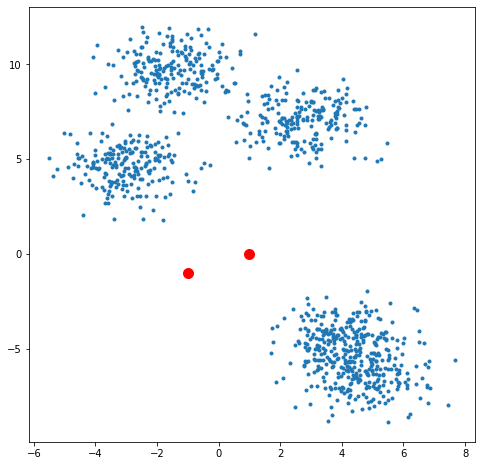

In [11]:
plt.figure(figsize=[8,8])
plt.plot(data[:,0], data[:,1], ".")
plt.plot(data[ano_index,0], data[ano_index,1], "o", c="r", markersize=10)

In [33]:
config={
	 'input_dim':5,
	 'hidden_dims':[16, 8],
	 'zc_dim':1,
	 'n_gmm':4,
	 'dropout_rate':0.25,
	 'lambda1':0.1,
	 'lambda2':0.001,
	 'lr' :1e-4,
	 'batch_size':128,
	 'epochs': 1000,
	 'save_path': '/home/sewon/anomaly_detection/DAGMM/'
	}

In [34]:
X_data = torch.FloatTensor(data)
y_label = np.zeros(len(X_data))
y_label[300] = 1.0
y_label[500] = 1.0
y_data = torch.FloatTensor(y_label)
train_data = TensorDataset(X_data, y_data)
train_loader = DataLoader(dataset = train_data, batch_size=config['batch_size'], shuffle=True)

In [35]:
model = DAGMM(config)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),config['lr'])

Sequential(
  (0): Linear(in_features=5, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=8, bias=True)
  (3): Tanh()
  (4): Linear(in_features=8, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=1, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=5, bias=True)
)


In [36]:
loss_trace, model_ex1 = train(model, optimizer, train_loader, config, device)

Training DAGMM... Epoch: 1, Loss: 29.190, Energy: -1.848255529999733
Training DAGMM... Epoch: 2, Loss: 28.467, Energy: -1.8038209974765778
Training DAGMM... Epoch: 3, Loss: 28.051, Energy: -1.7616847157478333
Training DAGMM... Epoch: 4, Loss: 27.568, Energy: -1.7101000249385834
Training DAGMM... Epoch: 5, Loss: 27.206, Energy: -1.672595962882042
Training DAGMM... Epoch: 6, Loss: 26.953, Energy: -1.632089450955391
Training DAGMM... Epoch: 7, Loss: 26.639, Energy: -1.6172342598438263
Training DAGMM... Epoch: 8, Loss: 26.371, Energy: -1.5710025429725647
Training DAGMM... Epoch: 9, Loss: 26.134, Energy: -1.5459013879299164
Training DAGMM... Epoch: 10, Loss: 25.967, Energy: -1.5470880568027496
Training DAGMM... Epoch: 11, Loss: 25.790, Energy: -1.5289133191108704
Training DAGMM... Epoch: 12, Loss: 25.621, Energy: -1.5104754120111465
Training DAGMM... Epoch: 13, Loss: 25.453, Energy: -1.4914417564868927
Training DAGMM... Epoch: 14, Loss: 25.364, Energy: -1.4810312017798424
Training DAGMM... 

In [50]:
def plot_loss_moment(losses):
    _, ax = plt.subplots(figsize=(8, 3), dpi=80)
    ax.plot(losses, 'blue', label='train', linewidth=1)
    ax.set_title('Loss change in training')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Iteration')
    ax.legend(loc='upper right')
    # plt.savefig(os.path.join(config['img_dir'], 'loss_dagmm.png'))

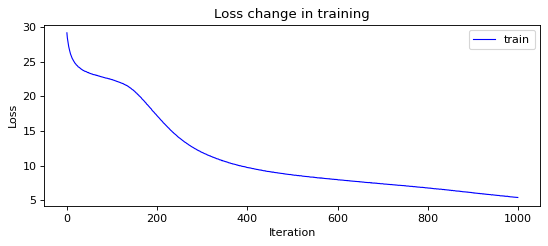

In [38]:
plot_loss_moment(loss_trace)

In [39]:
with torch.no_grad():
    X_data = X_data.to(device)
    _, _, z, gamma = model_ex1(X_data)
    sample_energy, _ = model_ex1.compute_sample_energy(z, sample_average=False)

Text(0, 0.5, 'Number of Sample(s)')

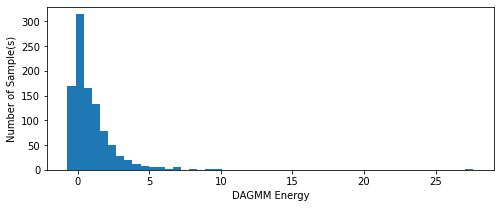

In [40]:
plt.figure(figsize=[8,3])
histinfo = plt.hist(sample_energy.cpu().numpy(), bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")

Text(0, 0.5, 'Energy')

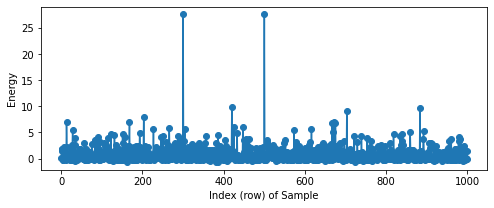

In [41]:
plt.figure(figsize=[8,3])
plt.plot(sample_energy.cpu().numpy(), "o-")
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")

In [43]:
data_np = X_data.cpu().numpy()
energy = sample_energy.cpu().numpy()

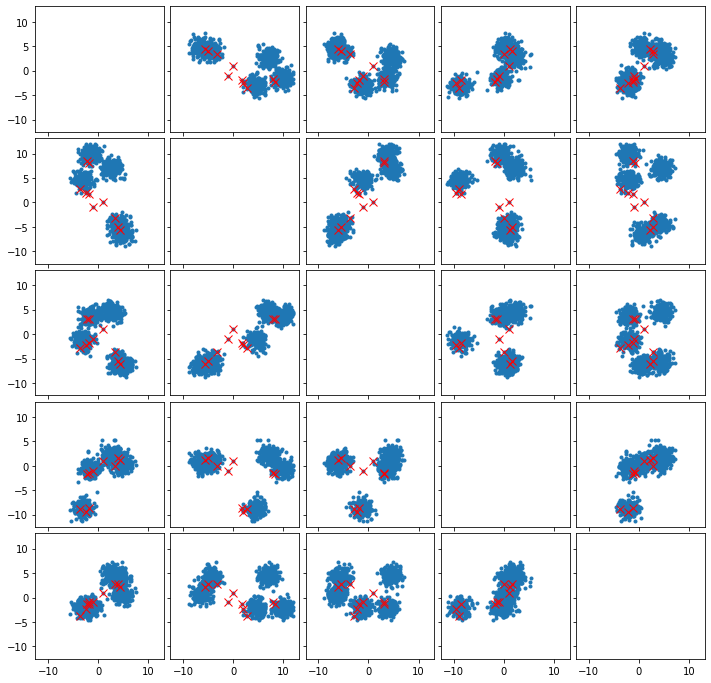

In [44]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[12,12], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data_np[:,col], data_np[:,row], ".")
            ano_index = np.arange(len(energy))[energy > np.percentile(energy, 99)]
            ax.plot(data_np[ano_index,col], data_np[ano_index,row], "x", c="r", markersize=8)

In [45]:
test_result = eval(model_ex1, train_loader, train_loader, device, 99)

N: 1000
phi :
 tensor([0.0169, 0.0095, 0.0156, 0.9580], device='cuda:0')
mu :
 tensor([[1.9650, 0.6354, 0.7538],
        [1.9893, 0.6810, 0.7255],
        [1.8555, 0.6094, 0.7697],
        [0.2460, 0.4307, 0.8969]], device='cuda:0')
cov :
 tensor([[[ 7.8136,  0.3711, -0.2477],
         [ 0.3711,  0.1594, -0.0985],
         [-0.2477, -0.0985,  0.0651]],

        [[ 7.6110,  0.2924, -0.2015],
         [ 0.2924,  0.2282, -0.1392],
         [-0.2015, -0.1392,  0.0911]],

        [[ 8.2297,  0.4285, -0.2805],
         [ 0.4285,  0.1277, -0.0792],
         [-0.2805, -0.0792,  0.0526]],

        [[ 8.1804,  0.3297, -0.1919],
         [ 0.3297,  0.0397, -0.0217],
         [-0.1919, -0.0217,  0.0141]]], device='cuda:0')
Threshold: 3.6014
Accuracy : 0.9920, Precision : 0.2000, Recall : 1.0000, F1-score : 0.3333


In [46]:
np.sum(test_result['pred'] == 1)

10

### 2. Arrhythmia 데이터

In [47]:
config={
	 'input_dim':274,
	 'hidden_dims':[10],
	 'zc_dim':2,
	 'n_gmm':2,
	 'dropout_rate':0.5,
	 'lambda1':0.1,
	 'lambda2':0.005,
	 'lr' :1e-4,
	 'batch_size':128,
	 'epochs': 10000,
	 'save_path': '/home/sewon/anomaly_detection/DAGMM/'
	}

In [48]:
arrhy_train_X, arrhy_train_y, arrhy_test_X, arrhy_test_y = NAD.Arrhythmia_train_test_split('/home/sewon/anomaly_detection/datasets/')
train_data = TensorDataset(torch.FloatTensor(arrhy_train_X), torch.FloatTensor(arrhy_train_y))
train_loader = DataLoader(dataset = train_data, batch_size=config['batch_size'], shuffle=True)

In [49]:
model = DAGMM(config)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),config['lr'])

Sequential(
  (0): Linear(in_features=274, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=2, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=274, bias=True)
)


In [50]:
loss_trace, model_ex2 = train(model, optimizer, train_loader, config, device)

Training DAGMM... Epoch: 1, Loss: 179474.641, Energy: -4.884520530700684
Training DAGMM... Epoch: 2, Loss: 161831.125, Energy: -4.772955656051636
Training DAGMM... Epoch: 3, Loss: 164479.250, Energy: -4.748773574829102
Training DAGMM... Epoch: 4, Loss: 139922.613, Energy: -4.592596530914307
Training DAGMM... Epoch: 5, Loss: 132762.668, Energy: -4.599896430969238
Training DAGMM... Epoch: 6, Loss: 128994.469, Energy: -4.514728307723999
Training DAGMM... Epoch: 7, Loss: 126160.930, Energy: -4.4675493240356445
Training DAGMM... Epoch: 8, Loss: 129254.848, Energy: -4.515700817108154
Training DAGMM... Epoch: 9, Loss: 128570.547, Energy: -4.469457149505615
Training DAGMM... Epoch: 10, Loss: 121279.477, Energy: -4.433470964431763
Training DAGMM... Epoch: 11, Loss: 118753.055, Energy: -4.416764974594116
Training DAGMM... Epoch: 12, Loss: 125677.328, Energy: -4.405277729034424
Training DAGMM... Epoch: 13, Loss: 101644.434, Energy: -4.362265586853027
Training DAGMM... Epoch: 14, Loss: 102945.039,

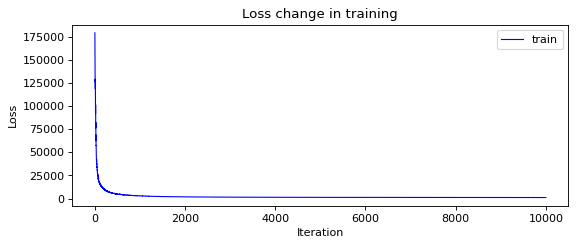

In [51]:
plot_loss_moment(loss_trace)

In [52]:
test_data = TensorDataset(torch.FloatTensor(arrhy_test_X), torch.FloatTensor(arrhy_test_y))
test_loader = DataLoader(dataset = test_data, batch_size=config['batch_size'], shuffle=False)

In [53]:
test_result = eval(model_ex2, train_loader, test_loader, device, 80)

N: 193
phi :
 tensor([0.9947, 0.0053], device='cuda:0')
mu :
 tensor([[-2.4224,  2.9332,  0.9536,  0.5595],
        [-0.1335, -0.0729,  1.0025, -0.0323]], device='cuda:0')
cov :
 tensor([[[ 9.9985e-01, -1.3253e+00,  2.1163e-02, -2.5640e-01],
         [-1.3253e+00,  1.7711e+00, -2.8004e-02,  3.3944e-01],
         [ 2.1163e-02, -2.8004e-02,  4.7273e-04, -5.6247e-03],
         [-2.5640e-01,  3.3944e-01, -5.6247e-03,  6.8342e-02]],

        [[ 4.2724e+00, -5.5912e+00,  9.0728e-02, -1.0979e+00],
         [-5.5912e+00,  7.3356e+00, -1.1898e-01,  1.4411e+00],
         [ 9.0728e-02, -1.1898e-01,  1.9553e-03, -2.3591e-02],
         [-1.0979e+00,  1.4411e+00, -2.3591e-02,  2.8587e-01]]],
       device='cuda:0')
Threshold: -0.4922
Accuracy : 0.7683, Precision : 0.5484, Recall : 0.5152, F1-score : 0.5312


### 3. KDD Cup 1999 데이터 (10% subset)

In [201]:
config={
	 'input_dim':118,
	 'hidden_dims':[60, 30, 10],
	 'zc_dim':1,
	 'n_gmm':4,
	 'dropout_rate':0.5,
	 'lambda1':0.1,
	 'lambda2':0.005,
	 'lr' :1e-4,
	 'batch_size':1024,
	 'epochs': 200,
	 'save_path': '/home/sewon/anomaly_detection/DAGMM/'
	}

In [202]:
# data = pd.read_csv("../datasets/kddcup.data_10_percent_corrected.csv")
# data.loc[data["target"] != "normal", 'target'] = 0
# data.loc[data["target"] == "normal", 'target'] = 1

# one_hot_protocol = pd.get_dummies(data["protocol_type"])
# one_hot_service = pd.get_dummies(data["service"])
# one_hot_flag = pd.get_dummies(data["flag"])

# data = data.drop("protocol_type",axis=1)
# data = data.drop("service",axis=1)
# data = data.drop("flag",axis=1)
    
# data = pd.concat([one_hot_protocol, one_hot_service,one_hot_flag, data],axis=1)
# proportions = data["target"].value_counts()
# print(proportions)
# print("Anomaly Percentage",proportions[1] / proportions.sum())

# cols_to_norm = ["duration", "src_bytes", "dst_bytes", "wrong_fragment", "urgent", 
#             "hot", "num_failed_logins", "num_compromised", "num_root", 
#             "num_file_creations", "num_shells", "num_access_files", "count", "srv_count", 
#             "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
#             "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
#             "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
#             "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate: continuous", "dst_host_srv_rerror_rate" ]

# # data.loc[:, cols_to_norm] = (data[cols_to_norm] - data[cols_to_norm].mean()) / data[cols_to_norm].std()
# min_cols = data.loc[data["target"]==0 , cols_to_norm].min()
# max_cols = data.loc[data["target"]==0 , cols_to_norm].max()

# data.loc[:, cols_to_norm] = (data[cols_to_norm] - min_cols) / (max_cols - min_cols)

In [203]:
class KDD99Loader(object):
    def __init__(self, data_path, mode="train"):
        self.mode=mode
        data = np.load(data_path)

        labels = data["kdd"][:,-1]
        features = data["kdd"][:,:-1]
        N, D = features.shape
        
        normal_data = features[labels==1]
        normal_labels = labels[labels==1]

        N_normal = normal_data.shape[0]

        attack_data = features[labels==0]
        attack_labels = labels[labels==0]

        N_attack = attack_data.shape[0]

        randIdx = np.arange(N_attack)
        np.random.shuffle(randIdx)
        N_train = N_attack // 2

        self.train = attack_data[randIdx[:N_train]]
        self.train_labels = attack_labels[randIdx[:N_train]]

        self.test = attack_data[randIdx[N_train:]]
        self.test_labels = attack_labels[randIdx[N_train:]]

        self.test = np.concatenate((self.test, normal_data),axis=0)
        self.test_labels = np.concatenate((self.test_labels, normal_labels),axis=0)


    def __len__(self):
        """
        Number of images in the object dataset.
        """
        if self.mode == "train":
            return self.train.shape[0]
        else:
            return self.test.shape[0]


    def __getitem__(self, index):
        if self.mode == "train":
            return np.float32(self.train[index]), np.float32(self.train_labels[index])
        else:
           return np.float32(self.test[index]), np.float32(self.test_labels[index])
        

def get_loader(data_path, batch_size, mode='train'):
    """Build and return data loader."""

    dataset = KDD99Loader(data_path, mode)

    shuffle = False
    if mode == 'train':
        shuffle = True

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle)
    return data_loader

In [205]:
train_loader = get_loader("../datasets/kdd_cup.npz", config['batch_size'], mode = 'train')

In [206]:
# kddrev_train_X, kddrev_train_y, kddrev_test_X, kddrev_test_y = NAD.KDDRev_train_test_split('http://kdd.ics.uci.edu/databases/kddcup99/')
# train_data = TensorDataset(torch.FloatTensor(kddrev_train_X), torch.FloatTensor(kddrev_train_y))
# train_loader = DataLoader(dataset = train_data, batch_size=config['batch_size'], shuffle=True)

In [207]:
model = DAGMM(config)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),config['lr'])

Sequential(
  (0): Linear(in_features=118, out_features=60, bias=True)
  (1): Tanh()
  (2): Linear(in_features=60, out_features=30, bias=True)
  (3): Tanh()
  (4): Linear(in_features=30, out_features=10, bias=True)
  (5): Tanh()
  (6): Linear(in_features=10, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=30, bias=True)
  (3): Tanh()
  (4): Linear(in_features=30, out_features=60, bias=True)
  (5): Tanh()
  (6): Linear(in_features=60, out_features=118, bias=True)
)


In [209]:
loss_trace, model_ex3 = train(model, optimizer, train_loader, config, device)

Training DAGMM... Epoch: 1, Loss: 11.100, Energy: -1.8646404503547038
Training DAGMM... Epoch: 2, Loss: 0.212, Energy: -1.7150948422471273
Training DAGMM... Epoch: 3, Loss: 0.175, Energy: -1.4077905840480451
Training DAGMM... Epoch: 4, Loss: 0.153, Energy: -1.6440797896729302
Training DAGMM... Epoch: 5, Loss: 0.137, Energy: -1.7562130923123704
Training DAGMM... Epoch: 6, Loss: 0.130, Energy: -1.7988727541313958
Training DAGMM... Epoch: 7, Loss: 0.141, Energy: -1.6922748641869456
Training DAGMM... Epoch: 8, Loss: 0.137, Energy: -1.7415060228908186
Training DAGMM... Epoch: 9, Loss: 0.147, Energy: -1.6794620469673394
Training DAGMM... Epoch: 10, Loss: 0.150, Energy: -1.6963855802398367
Training DAGMM... Epoch: 11, Loss: 0.178, Energy: -1.5859309404166704
Training DAGMM... Epoch: 12, Loss: 0.181, Energy: -1.5875100720789015
Training DAGMM... Epoch: 13, Loss: 0.183, Energy: -1.5975734695945818
Training DAGMM... Epoch: 14, Loss: 0.189, Energy: -1.5678358588022054
Training DAGMM... Epoch: 15,

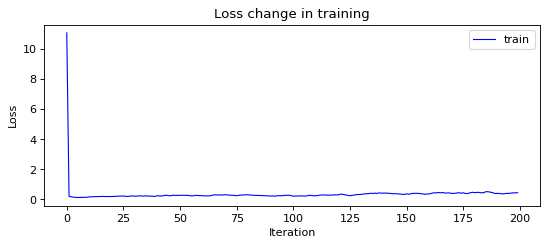

In [210]:
plot_loss_moment(loss_trace)

In [211]:
# test_data = TensorDataset(torch.FloatTensor(kddrev_test_X), torch.FloatTensor(kddrev_test_y))
# test_loader = DataLoader(dataset = test_data, batch_size=config['batch_size'], shuffle=False)

In [212]:
test_loader = get_loader("../datasets/kdd_cup.npz", config['batch_size'], mode = 'test')

In [213]:
test_result = eval(model_ex3, train_loader, test_loader, device, 80)

N: 198371
phi :
 tensor([1.7371e-04, 2.9887e-04, 1.1199e-04, 9.9942e-01], device='cuda:0')
mu :
 tensor([[-4.4818,  0.4353,  0.8961],
        [-4.0286,  0.5608,  0.8031],
        [-4.1856,  0.5170,  0.8355],
        [ 2.1249,  2.2521, -0.4543]], device='cuda:0')
cov :
 tensor([[[ 4.0723,  1.1184, -0.8317],
         [ 1.1184,  0.3077, -0.2287],
         [-0.8317, -0.2287,  0.1700]],

        [[ 7.7560,  2.1284, -1.5832],
         [ 2.1284,  0.5847, -0.4348],
         [-1.5832, -0.4348,  0.3234]],

        [[ 6.5575,  1.7998, -1.3388],
         [ 1.7998,  0.4946, -0.3677],
         [-1.3388, -0.3677,  0.2735]],

        [[18.0229,  4.9166, -3.6644],
         [ 4.9166,  1.3421, -1.0000],
         [-3.6644, -1.0000,  0.7453]]], device='cuda:0')
Threshold: 2.1848
Accuracy : 0.9499, Precision : 0.9412, Recall : 0.9042, F1-score : 0.9223


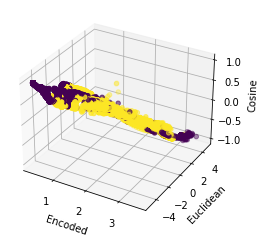

In [214]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_result['test_z'][:,1], test_result['test_z'][:,0], test_result['test_z'][:,2], c=test_result['test_labels'].astype(int))
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()

In [229]:
config={
	 'input_dim':118,
	 'hidden_dims':[60, 30, 10],
	 'zc_dim':1,
	 'n_gmm':2,
	 'dropout_rate':0.5,
	 'lambda1':0.1,
	 'lambda2':0.005,
	 'lr' :1e-4,
	 'batch_size':1024,
	 'epochs': 400,
	 'save_path': '/home/sewon/anomaly_detection/DAGMM/'
	}

In [230]:
train_loader = get_loader("../datasets/kdd_cup.npz", config['batch_size'], mode = 'train')

In [231]:
model = DAGMM(config)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),config['lr'])

Sequential(
  (0): Linear(in_features=118, out_features=60, bias=True)
  (1): Tanh()
  (2): Linear(in_features=60, out_features=30, bias=True)
  (3): Tanh()
  (4): Linear(in_features=30, out_features=10, bias=True)
  (5): Tanh()
  (6): Linear(in_features=10, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=30, bias=True)
  (3): Tanh()
  (4): Linear(in_features=30, out_features=60, bias=True)
  (5): Tanh()
  (6): Linear(in_features=60, out_features=118, bias=True)
)


In [232]:
loss_trace, model_ex4 = train(model, optimizer, train_loader, config, device)

Training DAGMM... Epoch: 1, Loss: 6.829, Energy: -2.947928775217115
Training DAGMM... Epoch: 2, Loss: -0.051, Energy: -2.5450297729256226
Training DAGMM... Epoch: 3, Loss: -0.069, Energy: -2.1697202650542113
Training DAGMM... Epoch: 4, Loss: -0.067, Energy: -2.038639511029745
Training DAGMM... Epoch: 5, Loss: -0.076, Energy: -2.0615942613365723
Training DAGMM... Epoch: 6, Loss: -0.073, Energy: -1.970738143650527
Training DAGMM... Epoch: 7, Loss: -0.050, Energy: -1.7309348085491927
Training DAGMM... Epoch: 8, Loss: -0.053, Energy: -1.764647920721585
Training DAGMM... Epoch: 9, Loss: -0.060, Energy: -1.846499058389172
Training DAGMM... Epoch: 10, Loss: -0.050, Energy: -1.7576027967266201
Training DAGMM... Epoch: 11, Loss: -0.045, Energy: -1.7024900876369673
Training DAGMM... Epoch: 12, Loss: -0.041, Energy: -1.6717063809178538
Training DAGMM... Epoch: 13, Loss: -0.037, Energy: -1.6391035914421082
Training DAGMM... Epoch: 14, Loss: -0.039, Energy: -1.6643861495342451
Training DAGMM... Epo

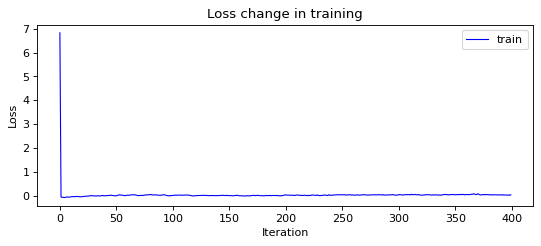

In [233]:
plot_loss_moment(loss_trace)

In [234]:
test_loader = get_loader("../datasets/kdd_cup.npz", config['batch_size'], mode = 'test')

In [235]:
test_result = eval(model_ex4, train_loader, test_loader, device, 80)

N: 198371
phi :
 tensor([1.4719e-05, 9.9998e-01], device='cuda:0')
mu :
 tensor([[  6.8803,   1.2193,  -0.1860],
        [-11.0201,   0.5987,   0.4759]], device='cuda:0')
cov :
 tensor([[[546.3476,  18.9594, -20.2185],
         [ 18.9594,   0.6581,  -0.7017],
         [-20.2185,  -0.7017,   0.7483]],

        [[485.5179,  16.8644, -17.9859],
         [ 16.8644,   0.5860,  -0.6248],
         [-17.9859,  -0.6248,   0.6664]]], device='cuda:0')
Threshold: 6.2066
Accuracy : 0.9569, Precision : 0.9488, Recall : 0.9185, F1-score : 0.9334
